In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [2]:
df = pd.read_csv('E:/Users/virtual_environments/crypto_price_predictor/data/eth_data.csv')
coin = 'ETH'
for i in range(df.shape[0]):
    df['Date'].iloc[i] = int(pd.Timestamp(pd.to_datetime(df['Date'].iloc[i],format= '%b %d, %Y' )).timestamp())
df.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,1679875200,1764.53,1773.91,1780.06,1747.56,383.13K,-0.54%
1,1679788800,1774.06,1742.32,1796.77,1739.39,371.97K,1.82%
2,1679702400,1742.34,1749.28,1761.66,1714.43,368.84K,-0.40%
3,1679616000,1749.26,1813.62,1818.53,1728.69,602.30K,-3.57%
4,1679529600,1814.08,1734.32,1852.48,1729.38,767.73K,4.59%


In [3]:
# Unix-time to 
df.Date = pd.to_datetime(df.Date, unit='s')

# Resampling to daily frequency
df.index = df.Date
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

In [4]:
# Box-Cox Transformations
df_month['close_box'], lmbda = stats.boxcox(df_month.Close)

In [5]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.close_box - df_month.close_box.shift(12)

In [6]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
# plt.figure(figsize=(15,7))

# # STL-decomposition
# sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

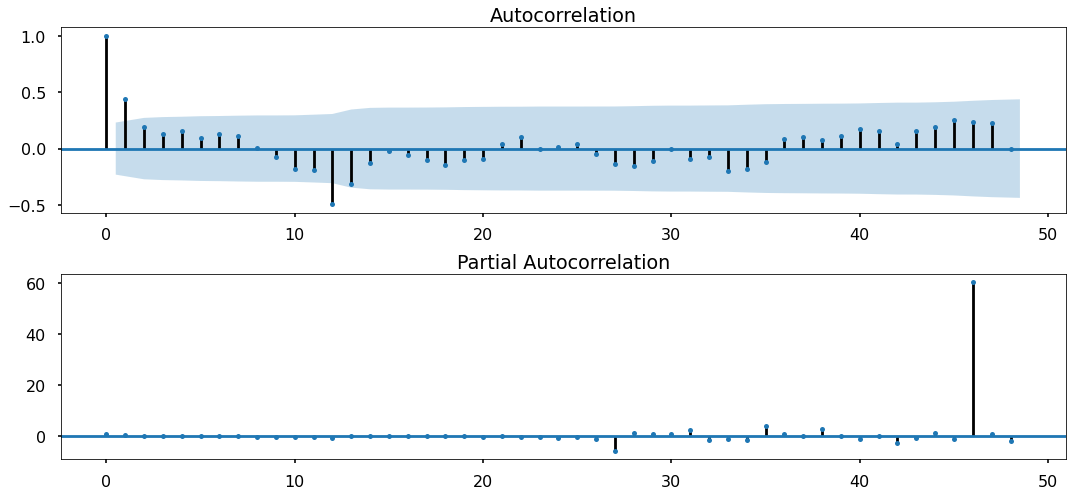

In [7]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [8]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12), enforce_stationarity=False).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [9]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
40  (2, 0, 2, 0)  109.646714
22  (1, 0, 2, 0)  109.793706
10  (0, 1, 2, 0)  110.244113
28  (1, 1, 2, 0)  110.404623
41  (2, 0, 2, 1)  110.928707
                                     SARIMAX Results                                      
Dep. Variable:                          close_box   No. Observations:                   85
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -49.823
Date:                            Thu, 30 Mar 2023   AIC                            109.647
Time:                                    21:32:17   BIC                            118.790
Sample:                                03-31-2016   HQIC                           113.072
                                     - 03-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

## Analysis of residues

Dickey–Fuller test:: p=0.000140


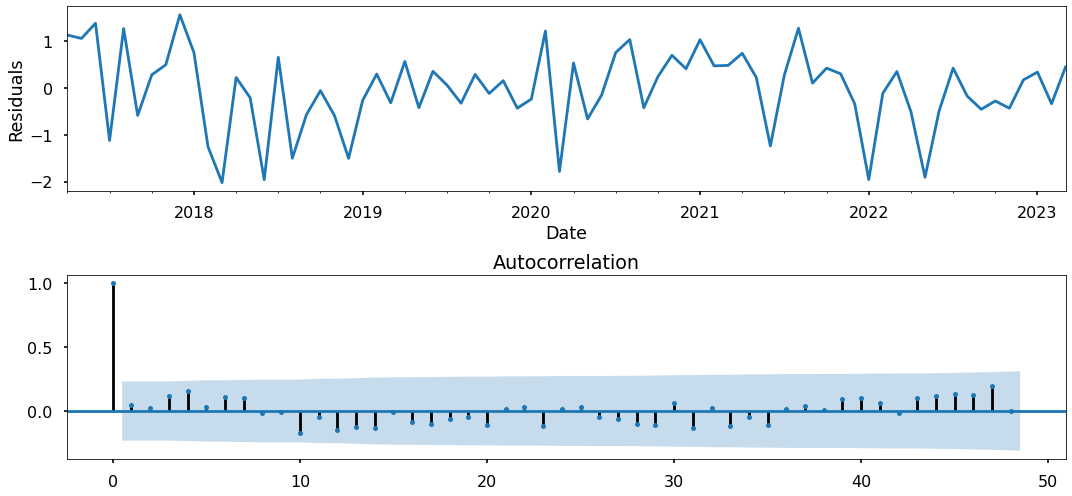

In [10]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## Prediction

In [13]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

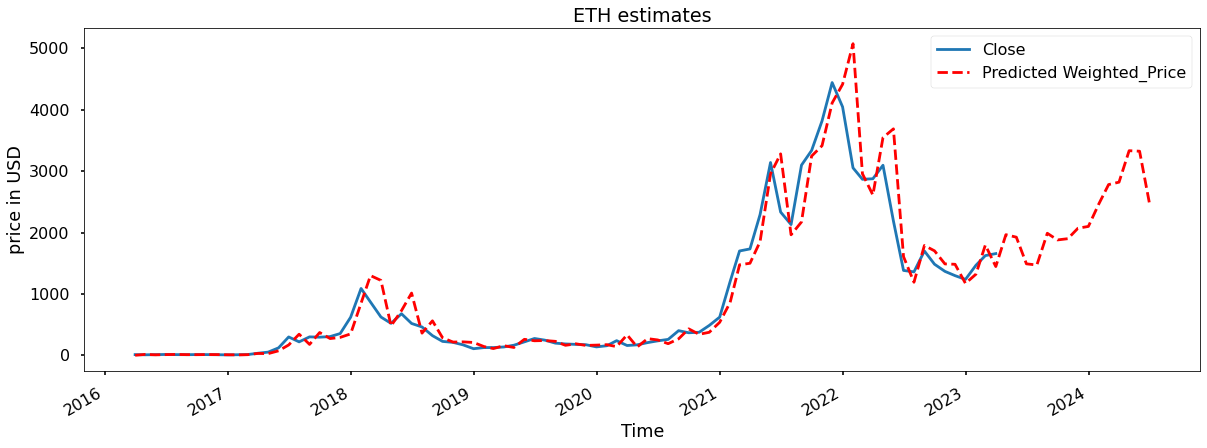

In [14]:
# Prediction
from datetime import datetime
df_month2 = df_month[['Close']]
date_list = [datetime(2023, 3, 31), datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30), 
             datetime(2023, 7, 31), datetime(2023, 8, 31), datetime(2023, 9, 30), datetime(2023, 10, 31),
             datetime(2023, 11, 30), datetime(2023, 12, 31), datetime(2024, 1, 31), datetime(2024, 2, 29),
             datetime(2024, 3, 31),datetime(2024, 4, 30),datetime(2024, 5, 31),datetime(2024, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=400), lmbda)


plt.figure(figsize=(20,7))
df_month2.Close.plot()
#dot
# df_month2.loc['2022-03-31'] = 30
# df_month2.loc['2022-02-28'] = 26
# df_month2.loc['2021-03-31'] = 35
# df_month2.loc['2021-02-28'] = 30

# df_month2.loc['2021-05-31'] = 58500
# df_month2.loc['2021-11-30'] = 62000
# df_month2.loc['2021-12-31'] = 58000

#doge
# df_month2.loc['2022-01-31'] = 0.11

#lite
# df_month2.loc['2018-01-31'] = 174.6
# df_month2.loc['2018-02-28'] = 225
# df_month2.loc['2018-03-31'] = 152.2
# df_month2.loc['2018-04-30'] = 136
# df_month2.loc['2018-05-31'] = 138
# df_month2.loc['2018-06-30'] = 80
# df_month2.loc['2018-07-31'] = 50
# df_month2.loc['2018-08-31'] = 52
# df_month2.loc['2018-12-31'] = 20

#avax
# df_month2.loc['2022-01-31'] = 100
# df_month2.loc['2022-02-28'] = 78
# df_month2.loc['2022-03-31'] = 76
# df_month2.loc['2022-04-30'] = 70
# df_month2.loc['2022-08-31'] = 19

df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title(f'{coin} estimates')
plt.ylabel('price in USD')
plt.xlabel('Time')
# plt.show()
plt.savefig(f'E:/Users/virtual_environments/crypto_price_predictor/output/{coin}_plot.png')

In [15]:
df_month2.forecast.head(50)

2016-03-31       1.000000
2016-04-30      15.510398
2016-05-31       8.337783
2016-06-30      11.708615
2016-07-31      15.054545
2016-08-31      11.340519
2016-09-30      10.724057
2016-10-31      12.907674
2016-11-30      11.992013
2016-12-31       9.581122
2017-01-31       7.450515
2017-02-28      10.787452
2017-03-31      31.330395
2017-04-30      27.973909
2017-05-31      73.880136
2017-06-30     169.059796
2017-07-31     344.254456
2017-08-31     178.192647
2017-09-30     371.525505
2017-10-31     273.302346
2017-11-30     292.300182
2017-12-31     349.274931
2018-01-31     850.342812
2018-02-28    1298.645888
2018-03-31    1220.199574
2018-04-30     480.237284
2018-05-31     727.782313
2018-06-30    1014.141509
2018-07-31     361.338798
2018-08-31     561.824070
2018-09-30     286.297421
2018-10-31     216.319120
2018-11-30     219.369728
2018-12-31     209.646105
2019-01-31     142.792068
2019-02-28     110.521683
2019-03-31     156.996172
2019-04-30     128.290638
2019-05-31  

In [16]:
df_month2 = df_month2[['Close', 'forecast']]
df_month2.dropna(inplace=True)

In [17]:
from sklearn import metrics

np.sqrt(metrics.mean_squared_error(df_month2.Close, df_month2.forecast))

355.07535522634885

In [18]:
import requests

x = requests.get('http://localhost:8000/api/analyzeTweets/')
x = x.json()

In [19]:
df_month2.head()

,Close,forecast
2016-03-31,11.717727,1.000000
2016-04-30,8.986667,15.510398
2016-05-31,11.334194,8.337783
2016-06-30,14.378000,11.708615
2016-07-31,11.886129,15.054545


In [20]:
from datetime import datetime
y = x['data'][coin]
factor = y['sum']/y['cnt']

mask = (df_month2.index > datetime.today().strftime('%Y-%m-%d'))
df_month2.loc[mask]['forecast'] *= factor
# factor


auto_regression = 73.4 precision
lstm = 87.0 
decision tree = 95.8 accuracy
regression = 97.5
SOFNN = 75.5 
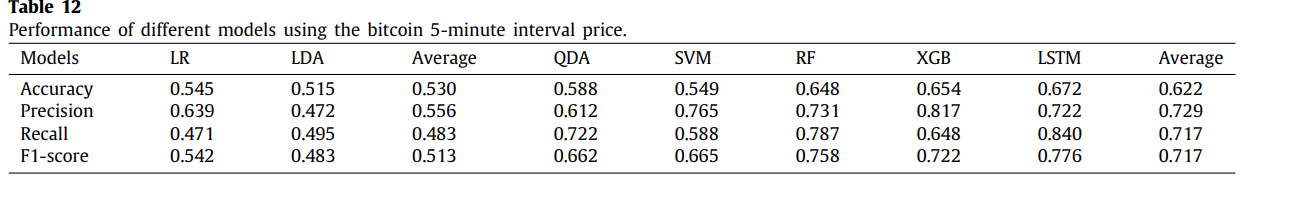

In [ ]:
import requests
import json

pol = requests.get('http://localhost:8000/api/analyzeTweets/')
data = json.loads(pol.text)
data = data['data'][coin]
score = data['sum']/data['cnt']

In [ ]:
score


0.08764468864468865